# Prepare the training and testing dataset

In [ ]:
from google.colab import files
uploaded= files.upload()


Saving fear2-img.jpg to fear2-img.jpg
Saving fear2-label.csv to fear2-label.csv
Saving final-labels.csv to final-labels.csv
Saving own-labels-final.csv to own-labels-final.csv
Saving own-reps-final.csv to own-reps-final.csv
Saving pred-reps.csv to pred-reps.csv
Saving reps-au-final.csv to reps-au-final.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

rep_data = pd.read_csv('reps-au-final.csv', sep=',', header=0)
label_data = pd.read_csv('final-labels.csv', sep=',', header=0)



df = pd.DataFrame(rep_data.to_numpy(), columns=[i for i in range(0,len(rep_data.to_numpy()[0]))])

le = LabelEncoder()
label = le.fit_transform(label_data)


X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    label, test_size=0.20, 
                                                    random_state=101)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Train using all the features (Random Forest Classifier)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=20,random_state=101)
classifier.fit(X_train,y_train.ravel())
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test.ravel(),y_pred))

0.973404255319149


# Defining various Genetic Algorithm Operators

Selection Operators :


In [ ]:
def roulette_selection(pop_after_fit,n_parents,scores):
    total_fitness_sum = np.sum(scores)
    probability_of_selection = list()
    population_after_selection = list()
    pop_after_fit_numpy = np.array(pop_after_fit)
    length = len(scores)
    scores_numpy = np.array(scores)
    for i in range(0,length):
      probability = scores[i]/total_fitness_sum
      probability_of_selection.append(probability)
    pop_indices=[]
    for i in range(0,length):
      pop_indices.append(i)
    from numpy.random import choice
    pop_after_fit_numpy = np.array(pop_after_fit)
    p_indices_numpy = np.array(pop_indices)
    prob_numpy = np.array(probability_of_selection)
    for i in range(0,length):
      population_after_selection.append(pop_after_fit_numpy[choice(p_indices_numpy,p=prob_numpy)])
    return population_after_selection  

def tournament_selection(pop_after_fit, n_parents,scores):
    pop_after_selection = list()
    pop_after_fit_numpy = np.array(pop_after_fit)
    scores_numpy = np.array(scores)
    for i in range(int(n_parents)):
      rand_ints = random.sample(range(0,n_parents),16)
      init_pop = pop_after_fit_numpy[rand_ints]
      init_score = scores_numpy[rand_ints]
      max_score_ind = np.argmax(init_score)
      pop_after_selection.append(pop_after_fit_numpy[max_score_ind])
            
    return pop_after_selection


def rank_based_selection(pop_after_fit, n_parents):
    probability_of_selection = []
    length = len(pop_after_fit)
    population_after_selection = []
    dec = 1/length
    curr_val = 1
    for i in range(0, length):
      probability_of_selection.append(curr_val)
      curr_val -= dec
    pop_indices=[]
    for i in range(0,length):
      pop_indices.append(i)
    from numpy.random import choice
    pop_indices = choice(pop_indices,length,probability_of_selection)
    for i in range(0,length):
      population_after_selection.append(pop_after_fit[pop_indices[i]])
    return population_after_selection
    

Crossover Operators:

In [ ]:
def single_point_crossover(pop_after_sel):
  population_nextgen=pop_after_sel
  b = random.randint(1,34)
  for i in range(len(pop_after_sel)):                                       
    parent1 = pop_after_sel[i]                                               
    parent2 = pop_after_sel[(i+1)%len(pop_after_sel)]
    first_child_genes1 = parent1[0:b]
    first_child = []                                          
    for x in first_child_genes1:
      first_child.append(x)
    for x in first_child_genes2:
      first_child.append(x)
    population_nextgen.append(first_child)
  return population_nextgen

def double_point_crossover(pop_after_sel):     
  population_nextgen=pop_after_sel
  for i in range(len(pop_after_sel)):                
      child=pop_after_sel[i]
      a= random.randint(1,34)
      b= random.randint(1,34)
      child[min(a,b):max(a,b)]=pop_after_sel[(i+1)%len(pop_after_sel)][min(a,b):max(a,b)]      
      population_nextgen.append(child)
  return population_nextgen

def uniform_crossover(pop_after_sel):
  pop_nextgen = pop_after_sel                                
  for i in range(0,len(pop_after_sel)):                       
    parent1 = pop_after_sel[i]
    parent2 = pop_after_sel[(i+1)%len(pop_after_sel)]
    child = []
    for j in range(0,len(parent1)):
      val = random.choice([parent1[j],parent2[j]])
      child.append(val)
    pop_nextgen.append(child)
  return pop_nextgen


Mutation Operators

In [ ]:
def mutation_flip_bits(pop_after_cross,mutation_rate=0.05):
  population_nextgen = []
  for i in range(0,len(pop_after_cross)):
    chromosome = pop_after_cross[i]
    to_be_flipped = np.random.randint(low=0, high=len(pop_after_cross[i]),size=1)[0]
    if np.random.random() < mutation_rate:
      chromosome[to_be_flipped] = not chromosome[to_be_flipped]
    population_nextgen.append(chromosome)
  return population_nextgen
                          


def mutation_bit_swap(offspring_crossover, mutation_rate=0.1):
  for idx in range(0,len(offspring_crossover)):
    mutation_gene1,mutation_gene2 = np.random.randint(low=0, high=len(offspring_crossover[idx]),size=2)
    if np.random.random() < mutation_rate:
      temp = offspring_crossover[idx][mutation_gene1]
      offspring_crossover[idx][mutation_gene1] = offspring_crossover[idx][mutation_gene2]
      offspring_crossover[idx][mutation_gene2] = temp
  return offspring_crossover

  

Genetic Algorithm :

Choose Operators

In [ ]:
selection_arg = 'tournament' #@param ["roulette", "tournament", "rank-based"]
crossover_arg = 'double-point' #@param ["single-point", "double-point", "uniform"]
mutation_arg = 'bit-swap' #@param ["bit-flip", "bit-swap"]


In [ ]:
#defining various steps required for the genetic algorithm
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population:
        classifier1 = RandomForestClassifier(n_estimators=20,random_state=0)
        classifier1.fit(X_train.iloc[:,chromosome],y_train.ravel())
        predictions = classifier1.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test.ravel(),predictions)/sum(chromosome))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(arg,pop_after_fit,n_parents,scores):
    if arg == 'roulette':
      return roulette_selection(pop_after_fit,n_parents,scores)
    elif arg == 'tournament':
      return tournament_selection(pop_after_fit, n_parents,scores)
    elif arg == 'rank-based':
      return rank_based_selection(pop_after_fit, n_parents)

def crossover(arg,pop_after_sel):
    if arg == 'single-point':
        return single_point_crossover(pop_after_sel)
    elif arg == 'double-point':
        return double_point_crossover(pop_after_sel)
    elif arg == 'uniform' :
        return uniform_crossover(pop_after_sel)

def mutation(arg,pop_after_cross,mutation_rate):
    if arg == 'bit-flip':
      return mutation_flip_bits(pop_after_cross,mutation_rate)
    elif arg == 'bit-swap':
      return mutation_bit_swap(pop_after_cross,mutation_rate)

def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print("Generation " + str(i) + ': ' + str(sum(scores[:10])/10))
        pop_after_sel = selection(selection_arg,pop_after_fit,n_parents,scores)
        pop_after_cross = crossover(crossover_arg,pop_after_sel)
        population_nextgen = mutation(mutation_arg,pop_after_cross,mutation_rate)    
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

# Applying Genetic Algorithms for Feature Selection

In [ ]:
import time
start = time.time()
import numpy as np
import random
 
chromo,score=generations(size=100,n_feat=35,n_parents=100,mutation_rate=0.10,
                     n_gen=4,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

print('Done')

end = time.time()
time_taken = end-start
print('Time taken : '+str(time_taken))

Generation 0: 0.03976595744680851
Generation 1: 0.047112462006079034
Generation 2: 0.055260047281323874
Generation 3: 0.055555555555555566
Done
Time taken : 28.453720331192017


Displaying the optimal solution

In [ ]:
classifier1 = RandomForestClassifier(n_estimators=20,random_state=0)
classifier1.fit(X_train.iloc[:,chromo[-1]],y_train.ravel())
predictions = classifier1.predict(X_test.iloc[:,chromo[-1]])
print("Accuracy score after genetic algorithm is= "+str(accuracy_score(y_test,predictions)))

Accuracy score after genetic algorithm is= 1.0


In [ ]:
df = pd.read_csv('reps-au-final.csv')
header_list = df.columns
sol = chromo[-1]
ans = []
for i in range(0,len(sol)):
  if sol[i] == True:
    ans.append(header_list[i])
print(ans)
print(len(ans))


[' AU04_r', ' AU09_r', ' AU12_r', ' AU14_r', ' AU15_r', ' AU20_r', ' AU23_r', ' AU25_r', ' AU45_r', ' AU02_c', ' AU04_c', ' AU06_c', ' AU14_c', ' AU17_c', ' AU23_c', ' AU25_c', ' AU28_c', ' AU45_c']
18


Testing on dataset consisting of our own images

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

rep_data2 = pd.read_csv('own-reps-final.csv', sep=',', header=0)
label_data2 = pd.read_csv('own-labels-final.csv', sep=',', header=0)

df2 = pd.DataFrame(rep_data2.to_numpy(), columns=[i for i in range(0,len(rep_data2.to_numpy()[0]))])

le2 = LabelEncoder()
label2 = le2.fit_transform(label_data2)
predictions = classifier1.predict(df2.iloc[:,chromo[-1]])
print(label2)
print(predictions)


[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

print("Accuracy score after genetic algorithm on our own dataset is= "+str(accuracy_score(label2.ravel(),predictions)))

Accuracy score after genetic algorithm on our own dataset is= 0.6666666666666666


Prediction on Images

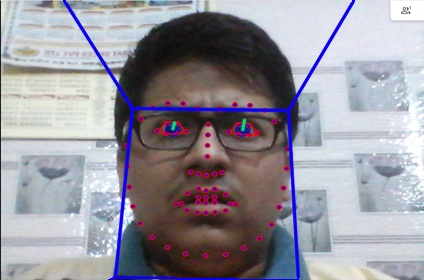

In [ ]:
from IPython.display import Image, display
display(Image('fear2-img.jpg'))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

rep_data3 = pd.read_csv('pred-reps.csv', sep=',', header=0)
label_data3 = pd.read_csv('fear2-label.csv', sep=',', header=0)
df3 = pd.DataFrame(rep_data3.to_numpy(), columns=[i for i in range(0,len(rep_data3.to_numpy()[0]))])
le3 = LabelEncoder()
label3 = le3.fit_transform(label_data3)




/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
prediction = classifier1.predict(df3.iloc[:,chromo[-1]])
acc = accuracy_score(label3,prediction)
if acc==1 and prediction[0]==0:
  print("Correctly identified emotion : Fear")
elif acc==1 and prediction[0]==1:
  print("Emotion displayed is not fear")
elif acc==0 and prediction[0]==0:
  print("Incorrect emotion identified : Fear")
elif acc==0 and prediction[0]==1:
  print("Incorrect emotion identified : Non-fear")

Correctly identified emotion : Fear
